# Postprocess wrfout file Tutorial

This tutorial will walk through postprocessing forecast data from your own WRF forecast model data using the wrfcast.py module within pvlib.

This tutorial has been tested against the following package versions:
* Python 
* IPython 
* pandas 
* matplotlib 
* netcdf4 1.4.2 

It should work with other Python and Pandas versions. It requires pvlib >= 0.3.0 and IPython >= 3.0.

Authors:
* Jeffrey Sward (jas983@cornell.edu), Cornell University, November 2019

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

In [43]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to WRF data file
datapath = os.path.join(pvlib_abspath, 'data', 'wrfout_d01_2011-01-24_01:00:00')

# Read in the wrfout file using the netCDF4.Dataset method (I think you can also do this with an xarray method)
netcdf_data = netCDF4.Dataset(datapath)
netcdf_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE: 2011-01-24_00:00:00
    SIMULATION_START_DATE: 2011-01-23_12:00:00
    WEST-EAST_GRID_DIMENSION: 192
    SOUTH-NORTH_GRID_DIMENSION: 192
    BOTTOM-TOP_GRID_DIMENSION: 36
    DX: 12000.0
    DY: 12000.0
    SKEBS_ON: 0
    SPEC_BDY_FINAL_MU: 1
    USE_Q_DIABATIC: 0
    GRIDTYPE: C
    DIFF_OPT: 1
    KM_OPT: 4
    DAMP_OPT: 0
    DAMPCOEF: 0.2
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 10
    RA_LW_PHYSICS: 1
    RA_SW_PHYSICS: 1
    SF_SFCLAY_PHYSICS: 2
    SF_SURFACE_PHYSICS: 2
    BL_PBL_PHYSICS: 5
    CU_PHYSICS: 3
    SF_LAKE_PHYSICS: 0
    SURFACE_INPUT_SOURCE: 1
    SST_UPDATE: 0
    GRID_FDDA: 1
    GFDDA_INTERVAL_M: 180
    GFDDA_END_H: 132
    GRID_SFDDA: 1
    SGFDDA_INTERVAL_M: 360
    SGFDDA_END_H: 120
    HYPSOMETRIC_OPT: 2
    USE_THETA_M: 0
    SF_URBAN_PHYSICS: 0
    SHCU_PHYSICS: 0
    MFSHCONV: 0
    FEEDBACK: 1


In [44]:
# Create an xarray.Dataset from the wrf qurery_variables.
query_variables = [
            'times',
            'T2',
            'U10',
            'V10',
            'CLDFRA',
            'COSZEN',
            'SWDDNI',
            'SWDDIF'
            ]
first = True
for key in query_variables:
    var = wrf.getvar(netcdf_data, key, timeidx=wrf.ALL_TIMES)
    if first:
        met_data = var
#         print(f'{met_data}\n')
        first = False
    else:
        with xr.set_options(keep_attrs=True):
            try:
                met_data = xr.merge([met_data, var])
            except ValueError:
                met_data = met_data.drop_vars('Time')
                met_data = xr.merge([met_data, var])
        
variables = {
            'times': 'Times',
            'XLAT': 'lat',
            'XLONG': 'lon',
            'T2': 'temp_air',
            'U10': 'wind_speed_u',
            'V10': 'wind_speed_v',
            'CLDFRA': 'cloud_fraction',
            'COSZEN': 'cos_zenith',
            'SWDDNI': 'dni',
            'SWDDIF': 'dhi' 
            }
met_data = xr.Dataset.rename(met_data, variables)
met_data = xr.Dataset.reset_coords(met_data, ['XTIME'], drop=True)
times = met_data.Times
# met_data = xr.Dataset.set_coords(met_data, ['Times'])
# met_data = xr.Dataset.reset_coords(met_data, ['Times'], drop=True)
ntimes = met_data.sizes['Time']
nlat = met_data.sizes['south_north']
nlon = met_data.sizes['west_east']
met_data

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    lon             (south_north, west_east) float32 -95.43335 ... -64.11832
    lat             (south_north, west_east) float32 30.952759 ... 47.507103
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    temp_air        (Time, south_north, west_east) float32 287.62427 ... 264....
    wind_speed_u    (Time, south_north, west_east) float32 0.31499797 ... 17....
    wind_speed_v    (Time, south_north, west_east) float32 1.1208413 ... -1.0...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 0.0 .....
    cos_zenith      (Time, south_north, west_east) float32 -0.23945779 ... -0...
    dni             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    dhi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0

In [45]:
met_data.drop_vars('any', errors='ignore')

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    lon             (south_north, west_east) float32 -95.43335 ... -64.11832
    lat             (south_north, west_east) float32 30.952759 ... 47.507103
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    temp_air        (Time, south_north, west_east) float32 287.62427 ... 264....
    wind_speed_u    (Time, south_north, west_east) float32 0.31499797 ... 17....
    wind_speed_v    (Time, south_north, west_east) float32 1.1208413 ... -1.0...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 0.0 .....
    cos_zenith      (Time, south_north, west_east) float32 -0.23945779 ... -0...
    dni             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    dhi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0

In [46]:
# Process the data using the WRF forecast model methods
fm = WRF()
# met_data = fm.process_data(met_data)
wind_speed10 = fm.uv_to_speed(met_data)
temp_air = fm.kelvin_to_celsius(met_data['temp_air'])
ghi = fm.dni_and_dhi_to_ghi(met_data['dni'], met_data['dhi'], met_data['cos_zenith'])
met_data

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    lon             (south_north, west_east) float32 -95.43335 ... -64.11832
    lat             (south_north, west_east) float32 30.952759 ... 47.507103
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    temp_air        (Time, south_north, west_east) float32 287.62427 ... 264....
    wind_speed_u    (Time, south_north, west_east) float32 0.31499797 ... 17....
    wind_speed_v    (Time, south_north, west_east) float32 1.1208413 ... -1.0...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 0.0 .....
    cos_zenith      (Time, south_north, west_east) float32 -0.23945779 ... -0...
    dni             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    dhi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0

In [47]:
# Process the data using the wrf-python package
height = wrf.getvar(netcdf_data, "height_agl", wrf.ALL_TIMES, units='m')
wspd = wrf.getvar(netcdf_data, 'wspd_wdir', wrf.ALL_TIMES, units='m s-1')[0,:]

#  Interpolate wind speeds to 100m height
wind_speed100 = wrf.interplevel(wspd, height, 100)

# Calculate wind power per square meter (units='W m-2')
air_density = 1000 
wpd = 0.5 * air_density * (wind_speed100) ** 3 

In [48]:
met_data['ghi'] = ghi
met_data['wind_speed10'] = wind_speed10
met_data['wind_speed100'] = wind_speed100
met_data['wpd'] = wpd
met_data

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    lon             (south_north, west_east) float32 -95.43335 ... -64.11832
    lat             (south_north, west_east) float32 30.952759 ... 47.507103
    wspd_wdir       <U4 'wspd'
    XLONG           (south_north, west_east) float32 -95.43335 ... -64.11832
    XLAT            (south_north, west_east) float32 30.952759 ... 47.507103
    XTIME           (Time) float32 780.0 840.0 900.0 ... 2040.0 2100.0 2160.0
    level           int64 100
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    temp_air        (Time, south_north, west_east) float32 287.62427 ... 264....
    wind_speed_u    (Time, south_north, west_east) float32 0.31499797 ... 17....
    wind_speed_v    (Time, south_north, west_east) float32 1.1208413 ... -1.0...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 0.0 .....
    cos_zenith      (Time, south_north, west_east) float32 -0.23945779 ... -0...
    dni             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    dhi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10    (Time, south_north, west_east) float32 1.1642632 ... 18.0...
    wind_speed100   (Time, south_north, west_east) float32 2.304195 ... 18.08...
    wpd             (Time, south_north, west_east) float32 6116.8477 ... 2957...

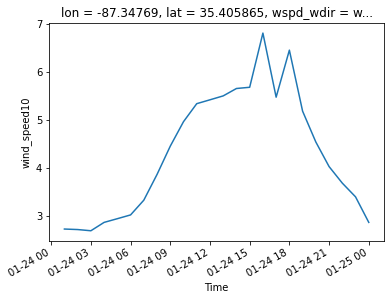

In [49]:
wspd_10 = met_data.wind_speed10.isel(south_north=45, west_east=60)
wspd_10 = wspd_10.squeeze()
wspd_10.plot()

In [50]:
wspd_10 = wspd_10.to_pandas()

In [53]:
type(wspd_10)


pandas.core.series.Series

In [32]:
new_filename_2 = './wind_speed_10_2011-01-24_01test.csv'

wspd_10 = wspd_10.to_pandas()
wspd_10.to_csv(new_filename_2)

In [8]:
# Fix a bug in how wrfout data is read in -- attributes must be strings to be written to NetCDF
for var in met_data.data_vars:
    try:
        met_data[var].attrs['projection'] = str(met_data[var].attrs['projection'])
    except KeyError:
        pass

In [9]:
# Fix another bug that creates a conflict in the 'coordinates' attribute
for var in met_data.data_vars:
    try:
        del met_data[var].attrs['coordinates'] 
    except KeyError:
        pass

In [10]:
met_data

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    lon             (south_north, west_east) float32 -95.43335 ... -64.11832
    lat             (south_north, west_east) float32 30.952759 ... 47.507103
    wspd_wdir       <U4 'wspd'
    XLONG           (south_north, west_east) float32 -95.43335 ... -64.11832
    XLAT            (south_north, west_east) float32 30.952759 ... 47.507103
    XTIME           (Time) float32 780.0 840.0 900.0 ... 2040.0 2100.0 2160.0
    level           int64 100
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    temp_air        (Time, south_north, west_east) float32 287.62427 ... 264....
    wind_speed_u    (Time, south_north, west_east) float32 0.31499797 ... 17....
    wind_speed_v    (Time, south_north, west_east) float32 1.1208413 ... -1.0...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 0.0 .....
    cos_zenith      (Time, south_north, west_east) float32 -0.23945779 ... -0...
    dni             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    dhi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10    (Time, south_north, west_east) float32 1.1642632 ... 18.0...
    wind_speed100   (Time, south_north, west_east) float32 2.304195 ... 18.08...
    wpd             (Time, south_north, west_east) float32 6116.8477 ... 2957...

In [11]:
met_data = xr.Dataset.reset_coords(met_data, ['wspd_wdir','XLONG', 'XLAT', 'XTIME', 'level'], drop=True)

In [12]:
met_data

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    lon             (south_north, west_east) float32 -95.43335 ... -64.11832
    lat             (south_north, west_east) float32 30.952759 ... 47.507103
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
    temp_air        (Time, south_north, west_east) float32 287.62427 ... 264....
    wind_speed_u    (Time, south_north, west_east) float32 0.31499797 ... 17....
    wind_speed_v    (Time, south_north, west_east) float32 1.1208413 ... -1.0...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 0.0 .....
    cos_zenith      (Time, south_north, west_east) float32 -0.23945779 ... -0...
    dni             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    dhi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10    (Time, south_north, west_east) float32 1.1642632 ... 18.0...
    wind_speed100   (Time, south_north, west_east) float32 2.304195 ... 18.08...
    wpd             (Time, south_north, west_east) float32 6116.8477 ... 2957...

In [ ]:
# Write the processed data back to a wrfout NetCDF file
new_filename_1 = './wrfout_processed_d01_2011-01-24_01:00:00.nc'
met_data.to_netcdf(path=new_filename_1)